# 프로젝트: ResNet Ablation Study

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

# Convolution Block 만들기

In [2]:
# Conv - BN - Activation 세개의 레이어로 이루어진 블럭 생성
# 이 블럭을 쌓아서 ResNet Unit과 PlainNet Unit을 구성 

def build_conv_block(input_layer, 
                     channel=64,
                     kernel_size=3, 
                     strides=1,
                     activation='relu',
                     block_num=1,
                     unit_num=1,
                     stage_num=1):
    # input
    x = input_layer

    # CNN
    x = keras.layers.Conv2D(channel, kernel_size, strides, padding = 'same',
                            name = f'stage{stage_num}_{unit_num}_Conv{block_num}')(x)

    # BN
    x = keras.layers.BatchNormalization(name = f'stage{stage_num}_{unit_num}_BN{block_num}')(x)

    if activation: # 유닛의 마지막 블럭은 add 이후 activation이 들어가므로 
                   # activation을 제외할 수 있어야 함
        x = keras.layers.Activation(activation = activation,
                                    name = f'stage{stage_num}_{unit_num}_ReLU{block_num}')(x)

    return x

## 1) ResNet 기본 블록 구성하기

In [3]:
def build_residual_unit(input_layer,
                         unit_num=1,
                         stage_num=1,
                         is_50=True,
                         channel=64):
    # input
    x = input_layer

    if is_50:
        for unit in range(unit_num):
            if unit == 0: # 유닛의 첫번째 레이어에서는 stride = 2 
                skip_layer = build_conv_block(x,channel*4,1,2,False,0,unit+1,stage_num)
                          # 해당 유닛의 마지막 출력과 더해진 후 activation 되어야 함
                x = build_conv_block(x,channel,1,2,'relu',1,unit+1,stage_num)
                
            else:
                skip_layer = x
                x = build_conv_block(x,channel,1,1,'relu',1,unit+1,stage_num)

            x = build_conv_block(x,channel,3,1,'relu',2,unit+1,stage_num)            
            x = build_conv_block(x,channel*4,1,1,False,3,unit+1,stage_num)
                          # skip_layer와 더해진 후 activation 되어야 함
            x = keras.layers.Add(name = f'stage{stage_num}_Add{unit+1}')([x, skip_layer])
            x = keras.layers.Activation('relu',
                                        name = f'stage{stage_num}_{unit+1}_ReLU3')(x)

    else:
        for unit in range(unit_num):
            if stage_num > 2 and unit == 0:
                          # 첫번째 유닛을 제외한 유닛의 첫번째 레이어에서는 stride = 2 
                skip_layer = build_conv_block(x,channel,1,2,False,0,unit+1,stage_num)
                x = build_conv_block(x,channel,3,2,'relu',1,unit+1,stage_num)
                
            else:
                skip_layer = x
                          # 첫번째 유닛은 maxpooling 후 입력되므로 strides = 1
                x = build_conv_block(x,channel,3,1,'relu',1,unit+1,stage_num)
            
            x = build_conv_block(x,channel,3,1,False,2,unit+1,stage_num)
            x = keras.layers.Add(name = f'stage{stage_num}_Add{unit+1}')([x, skip_layer])
            x = keras.layers.Activation('relu',
                                        name = f'stage{stage_num}_{unit+1}_ReLU2')(x)

    return x


# ResNet 모델 구성하기

In [4]:
def build_resnet(input_shape=(32,32,3), is_50=True, num_classes=10):
    if num_classes == 1: # 이진 분류일 때 
        activation='sigmoid'
    else:                # 다중 분류일 때
        activation='softmax'

    unit_num = [3,4,6,3] # 한 유닛에 쌓이는 conv_block의 개수
    input_layer = keras.layers.Input(shape=input_shape)
    x = input_layer
    #if is_50: # 제로패딩이 있길래 시도해보려다 실패...
    #    x = keras.layers.ZeroPadding2D() 

    x = build_conv_block(x,64,7,2)
    x = keras.layers.MaxPool2D(pool_size=2, 
                               strides=2,
                               name = 'stage1_1_maxpooling')(x)

    for i, unit in enumerate(unit_num):
        stage = i+2
        channel = 64*(2**i) # channel=[64,128,256,512]
        x = build_residual_unit(x,unit,stage,is_50,channel) 

    x = keras.layers.AveragePooling2D((1,1), name = 'Avg_Pool')(x)
    x = keras.layers.Flatten(name='Flatten')(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           name='predictions')(x)
    # 모델 이름 다르게 출력
    if is_50:
        model = keras.Model(inputs=input_layer, outputs=x, name='ResNet50')
    else:
        model = keras.Model(inputs=input_layer, outputs=x, name='ResNet34')

    return model

In [5]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True)
resnet_50.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_1_Conv1 (Conv2D)         (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
stage1_1_BN1 (BatchNormalizatio (None, 16, 16, 64)   256         stage1_1_Conv1[0][0]             
__________________________________________________________________________________________________
stage1_1_ReLU1 (Activation)     (None, 16, 16, 64)   0           stage1_1_BN1[0][0]               
___________________________________________________________________________________________

In [6]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False)
resnet_34.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_1_Conv1 (Conv2D)         (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
stage1_1_BN1 (BatchNormalizatio (None, 16, 16, 64)   256         stage1_1_Conv1[0][0]             
__________________________________________________________________________________________________
stage1_1_ReLU1 (Activation)     (None, 16, 16, 64)   0           stage1_1_BN1[0][0]               
___________________________________________________________________________________________

# PlainNet 기본 블록 구성하기

모델을 한번에 구성할 수도 있지만 ResNet과 같은 방식으로 구성하기 위해 유닛을 생성

Ablation Study를 위해 ResNet의 일부를 주석 처리 해서 제외시킴

그거 빼곤 그대로!

In [7]:
def build_plain_unit(input_layer,
                   unit_num=1,
                   stage_num=1,
                   is_50=True,
                   channel=64):
    x = input_layer

    if is_50:
        for unit in range(unit_num):
            if unit == 0:
                #skip_layer = build_conv_block(x,channel*4,1,2,False,0,unit+1,stage_num)
                x = build_conv_block(x,channel,1,2,'relu',1,unit+1,stage_num)
                
            else:
                #skip_layer = x
                x = build_conv_block(x,channel,1,1,'relu',1,unit+1,stage_num)

            x = build_conv_block(x,channel,3,1,'relu',2,unit+1,stage_num)            
            x = build_conv_block(x,channel*4,1,1,'relu',3,unit+1,stage_num)
            #x = keras.layers.Add(name = f'stage{stage_num}_Add{unit+1}')([x, skip_layer])
            #x = keras.layers.Activation('relu', name = f'stage{stage_num}_{unit+1}_ReLU3')(x)
    
    else:
        for unit in range(unit_num):
            if stage_num > 2 and unit == 0:
                #skip_layer = build_conv_block(x,channel,1,2,False,0,unit+1,stage_num)
                x = build_conv_block(x,channel,3,2,'relu',1,unit+1,stage_num)
                
            else:
                #skip_layer = x
                x = build_conv_block(x,channel,3,1,'relu',1,unit+1,stage_num)
            
            x = build_conv_block(x,channel,3,1,'relu',2,unit+1,stage_num)
            #x = keras.layers.Add(name = f'stage{stage_num}_Add{unit+1}')([x, skip_layer])
            #x = keras.layers.Activation('relu', name = f'stage{stage_num}_{unit+1}_ReLU2')(x)

    return x



# PlainNet 모델 구성하기

ResNet과 똑같은 코드

In [8]:
def build_plainnet(input_shape=(32,32,3), is_50=True, num_classes=10):
    if num_classes == 1:
        activation='sigmoid'
    else:
        activation='softmax'
    unit_num = [3,4,6,3]
    with tf.name_scope('Input Layer'):
        input_layer = keras.layers.Input(shape=input_shape)
    x = input_layer
    #if is_50:
    #    x = keras.layers.ZeroPadding2D()

    with tf.name_scope('Stage1'):
        with tf.name_scope('Stage1_Conv1_64,7,2'):
            x = build_conv_block(x,64,7,2)
        with tf.name_scope('Stage1_Pool'):
            x = keras.layers.MaxPool2D(pool_size=2, 
                                       strides=2,
                                       name = 'stage1_1_maxpooling')(x)

    for i, unit in enumerate(unit_num):
        stage = i+2
        channel = 64*(2**i)
        x = build_plain_unit(x,unit,stage,is_50,channel)

    x = keras.layers.AveragePooling2D((1,1), name = 'Avg_Pool')(x)
    x = keras.layers.Flatten(name='Flatten')(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           name='predictions')(x)
    
    if is_50:
        model = keras.Model(inputs=input_layer, outputs=x, name='PlainNet50')
    else:
        model = keras.Model(inputs=input_layer, outputs=x, name='PlainNet34')

    return model

In [9]:
plainnet_34 = build_plainnet(input_shape=(32,32,3), is_50=False)
plainnet_34.summary()

Model: "PlainNet34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
stage1_1_Conv1 (Conv2D)      (None, 16, 16, 64)        9472      
_________________________________________________________________
stage1_1_BN1 (BatchNormaliza (None, 16, 16, 64)        256       
_________________________________________________________________
stage1_1_ReLU1 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
stage1_1_maxpooling (MaxPool (None, 8, 8, 64)          0         
_________________________________________________________________
stage2_1_Conv1 (Conv2D)      (None, 8, 8, 64)          36928     
_________________________________________________________________
stage2_1_BN1 (BatchNormaliza (None, 8, 8, 64)          2

In [10]:
plainnet_50 = build_plainnet(input_shape=(32,32,3), is_50=True)
plainnet_50.summary()

Model: "PlainNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
stage1_1_Conv1 (Conv2D)      (None, 16, 16, 64)        9472      
_________________________________________________________________
stage1_1_BN1 (BatchNormaliza (None, 16, 16, 64)        256       
_________________________________________________________________
stage1_1_ReLU1 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
stage1_1_maxpooling (MaxPool (None, 8, 8, 64)          0         
_________________________________________________________________
stage2_1_Conv1 (Conv2D)      (None, 4, 4, 64)          4160      
_________________________________________________________________
stage2_1_BN1 (BatchNormaliza (None, 4, 4, 64)          2

# 데이터셋 준비

In [11]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [12]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [13]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_val))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [14]:
# 모델에 넣어주기 전 정규화(normalize)

def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224]) # 이미지 리사이징 까먹지말기!
    return tf.cast(image, tf.float32) / 255., label

In [15]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [16]:
# 카테고리 개수 확인

ds_info.features["label"].num_classes

2

In [17]:
# 카테고리 이름 확인

ds_info.features["label"].names

['cat', 'dog']

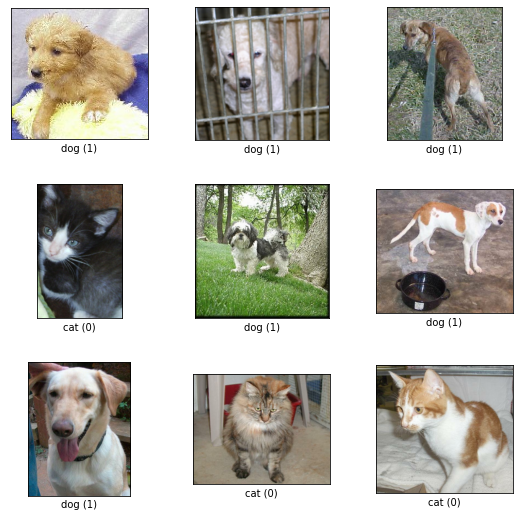

In [18]:
# 트레인 이미지 샘플 확인

fig = tfds.show_examples(ds_train, ds_info)

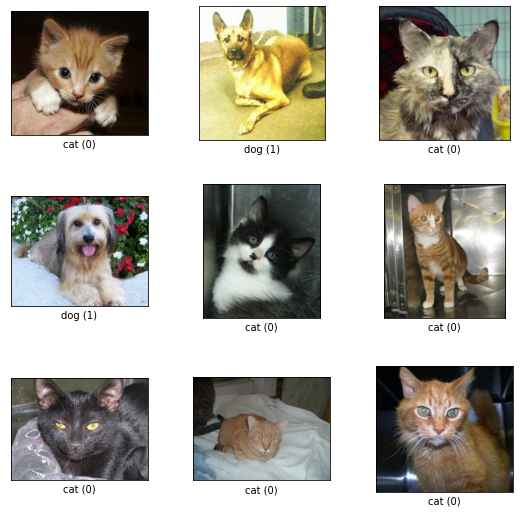

In [19]:
# 테스트 이미지 샘플 확인

fig = tfds.show_examples(ds_val, ds_info)

In [20]:
BATCH_SIZE = 32
EPOCH = 40

In [21]:
# cats_vs_dogs 데이터셋 만들기

(ds_train, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_val = apply_normalize_on_dataset(ds_val, batch_size=BATCH_SIZE)

텐서보드 적용 코드

```python
import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
```

In [22]:
# cats_vs_dogs

plainnet_34 = build_plainnet(input_shape=(224,224,3), is_50=False, num_classes=1)

plainnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain34 = plainnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
    # callbacks=[tensorboard_callback]
)

Epoch 1/40
581/581 [==============================] - 283s 446ms/step - loss: 0.7581 - accuracy: 0.5205 - val_loss: 0.9767 - val_accuracy: 0.5290
Epoch 2/40
581/581 [==============================] - 243s 419ms/step - loss: 0.7613 - accuracy: 0.5178 - val_loss: 1.3443 - val_accuracy: 0.5273
Epoch 3/40
581/581 [==============================] - 244s 419ms/step - loss: 0.7471 - accuracy: 0.5330 - val_loss: 1.1480 - val_accuracy: 0.5084
Epoch 4/40
581/581 [==============================] - 243s 419ms/step - loss: 0.7410 - accuracy: 0.5403 - val_loss: 4.8246 - val_accuracy: 0.4967
Epoch 5/40
581/581 [==============================] - 243s 419ms/step - loss: 0.7339 - accuracy: 0.5399 - val_loss: 2.0835 - val_accuracy: 0.5343
Epoch 6/40
581/581 [==============================] - 243s 419ms/step - loss: 0.7055 - accuracy: 0.5829 - val_loss: 0.8236 - val_accuracy: 0.5825
Epoch 7/40
581/581 [==============================] - 243s 419ms/step - loss: 0.6644 - accuracy: 0.6349 - val_loss: 0.7482 -

In [23]:
plainnet_50 = build_plainnet(input_shape=(224,224,3), is_50=True, num_classes=1)

plainnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain50 = plainnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
    # callbacks=[tensorboard_callback]
)

Epoch 1/40
581/581 [==============================] - 242s 352ms/step - loss: 0.7608 - accuracy: 0.5159 - val_loss: 0.9844 - val_accuracy: 0.4965
Epoch 2/40
581/581 [==============================] - 169s 290ms/step - loss: 0.7712 - accuracy: 0.5081 - val_loss: 2.3496 - val_accuracy: 0.4987
Epoch 3/40
581/581 [==============================] - 169s 291ms/step - loss: 0.7796 - accuracy: 0.5069 - val_loss: 7.6936 - val_accuracy: 0.4935
Epoch 4/40
581/581 [==============================] - 169s 292ms/step - loss: 0.7743 - accuracy: 0.5057 - val_loss: 1.0651 - val_accuracy: 0.4909
Epoch 5/40
581/581 [==============================] - 169s 291ms/step - loss: 0.7717 - accuracy: 0.4974 - val_loss: 3.4619 - val_accuracy: 0.5119
Epoch 6/40
581/581 [==============================] - 169s 291ms/step - loss: 0.7693 - accuracy: 0.5072 - val_loss: 1.5825 - val_accuracy: 0.5212
Epoch 7/40
581/581 [==============================] - 169s 291ms/step - loss: 0.7738 - accuracy: 0.5089 - val_loss: 1.8190 -

In [24]:
resnet_34 = build_resnet(input_shape=(224,224,3), is_50=False, num_classes=1)

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_res34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
    # callbacks=[tensorboard_callback]
)

Epoch 1/40
581/581 [==============================] - 272s 445ms/step - loss: 0.9322 - accuracy: 0.5420 - val_loss: 0.9817 - val_accuracy: 0.5517
Epoch 2/40
581/581 [==============================] - 254s 438ms/step - loss: 0.8189 - accuracy: 0.5819 - val_loss: 1.0643 - val_accuracy: 0.6039
Epoch 3/40
581/581 [==============================] - 254s 438ms/step - loss: 0.7221 - accuracy: 0.6469 - val_loss: 0.6898 - val_accuracy: 0.6494
Epoch 4/40
581/581 [==============================] - 254s 438ms/step - loss: 0.6169 - accuracy: 0.6987 - val_loss: 0.6634 - val_accuracy: 0.6840
Epoch 5/40
581/581 [==============================] - 254s 437ms/step - loss: 0.5620 - accuracy: 0.7287 - val_loss: 0.6773 - val_accuracy: 0.6848
Epoch 6/40
581/581 [==============================] - 254s 438ms/step - loss: 0.5018 - accuracy: 0.7679 - val_loss: 0.6429 - val_accuracy: 0.7317
Epoch 7/40
581/581 [==============================] - 256s 440ms/step - loss: 0.4208 - accuracy: 0.8147 - val_loss: 0.7021 -

In [25]:
resnet_50 = build_resnet(input_shape=(224,224,3), is_50=True, num_classes=1)

resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_res50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
    # callbacks=[tensorboard_callback]
)

Epoch 1/40
581/581 [==============================] - 211s 332ms/step - loss: 0.9611 - accuracy: 0.5228 - val_loss: 0.8943 - val_accuracy: 0.5171
Epoch 2/40
581/581 [==============================] - 195s 335ms/step - loss: 0.9313 - accuracy: 0.5288 - val_loss: 1.2626 - val_accuracy: 0.5321
Epoch 3/40
581/581 [==============================] - 191s 329ms/step - loss: 0.9073 - accuracy: 0.5411 - val_loss: 0.9778 - val_accuracy: 0.5370
Epoch 4/40
581/581 [==============================] - 191s 329ms/step - loss: 0.8514 - accuracy: 0.5593 - val_loss: 1.7427 - val_accuracy: 0.5072
Epoch 5/40
581/581 [==============================] - 191s 329ms/step - loss: 0.8503 - accuracy: 0.5624 - val_loss: 0.8181 - val_accuracy: 0.5355
Epoch 6/40
581/581 [==============================] - 192s 330ms/step - loss: 0.8298 - accuracy: 0.5784 - val_loss: 1.1432 - val_accuracy: 0.5448
Epoch 7/40
581/581 [==============================] - 191s 329ms/step - loss: 0.8112 - accuracy: 0.5853 - val_loss: 1.0446 -

텐서보드 적용 코드

```python
!tensorboard dev upload --logdir logs --name "Model" --description "BlahBlah"
```

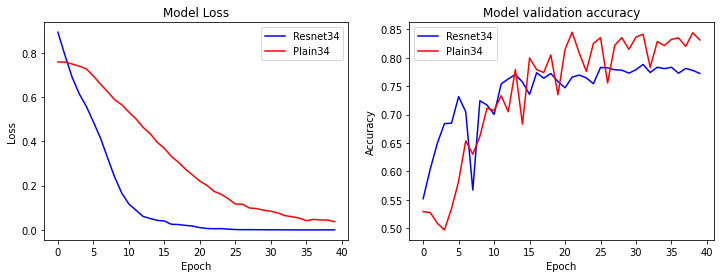

In [28]:
# ResNet34 vs PlainNet34
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_res34.history['loss'], 'b')
plt.plot(history_plain34.history['loss'], 'r')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Resnet34', 'Plain34'])


plt.subplot(1, 2, 2)
plt.plot(history_res34.history['val_accuracy'], 'b')
plt.plot(history_plain34.history['val_accuracy'], 'r')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Resnet34', 'Plain34'])

plt.show()

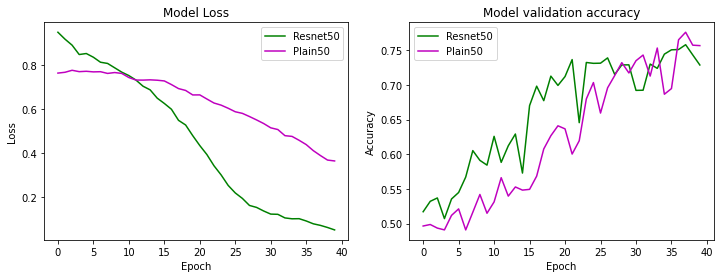

In [29]:
# ResNet50 vs PlainNet50
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_res50.history['loss'], 'g')
plt.plot(history_plain50.history['loss'], 'm')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Resnet50', 'Plain50'])


plt.subplot(1, 2, 2)
plt.plot(history_res50.history['val_accuracy'], 'g')
plt.plot(history_plain50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Resnet50', 'Plain50'])

plt.show()

In [38]:
def avg(list):           # val_accuracy의 평균을 구하는 함수
    x = np.array(list)
    x = np.mean(x)
    x = round(100*x,4)
    return x

In [43]:
import pandas as pd

val_acc = {
    'PlainNet': [
        avg(history_plain34.history['val_accuracy']),
        avg(history_plain50.history['val_accuracy'])        
    ],
    'ResNet': [
        avg(history_res34.history['val_accuracy']),
        avg(history_res50.history['val_accuracy'])
    ]        
}

ablation_result = pd.DataFrame(val_acc, index=['34 layers', '50 layers'])
ablation_result

,PlainNet,ResNet
34 layers,74.3587,74.1449
50 layers,62.3573,66.2955


In [44]:
val_acc_after20 = {
    'PlainNet': [
        avg(history_plain34.history['val_accuracy'][20:]),
        avg(history_plain50.history['val_accuracy'][20:])        
    ],
    'ResNet': [
        avg(history_res34.history['val_accuracy'][20:]),
        avg(history_res50.history['val_accuracy'][20:])
    ]        
}

ablation_result2 = pd.DataFrame(val_acc_after20, index=['34 layers', '50 layers'])
ablation_result2

,PlainNet,ResNet
34 layers,82.0394,77.4522
50 layers,70.6746,72.5594


# 결과

### Trainong Loss

- 처음에 ResNet이 PlainNet보다 loss가 높았던 걸로 봐선 skip layer에 적응하는데 시간이 필요한 것 같다
- 그래도 ResNet이 더 빠르게 loss 가 감소해서 금방 안정화 되는 모습을 보인다

### Val_accuracy_34_layer

- 학습 초중반부까지는 ResNet이 전반적으로 결과가 좋았으나 초반에 낮은 정확도에서 수렴해버린다
- PlainNet이 비틀비틀하면서도 ResNet 보다 위쪽에서 수렴하는 걸 생각하면 매우 안타까운 결과..
- 논문에서 ResNet34의 Top-1 error가 25% 정도였던 걸 생각하면 이 수치가 맞는 것 같긴 한데
- PlainNet의 수치는 차이가 있는걸로 봐선 학습이 더 진행되더라도 PlainNet이 깔끔하게 수렴하지 못하고 계속 왔다갔다 할 수도 있을 것 같다. (그래서 평균 값이 떨어지는게 아닐까)

### Val_accuracy_50_layer

- 사실 50layer의 경우 제대로 수렴하지 못한 상태에서 끝나버려서 아쉬운데...
- 둘 다 34layer의 초반과 비슷하게
- PlainNet은 여전히 비틀비틀하면서 정확도를 높여가고 있고
- ResNet은 초반에는 크게 꺾이기도 했지만 후반에서는 안정적으로 수렴하려는 형태이다.
- 40회까지의 결과만 보면 원하는 결과가 나오기는 했다
- 'ResNet에서 skip layer를 제거하면 정확도가 떨어진다'
- 그런데 한 열번이나 스무번 정도 더 돌렸을 때 34layer 처럼 되지 않을거라는 보장이 없다 ^^..

다음번에 다시 돌려볼때는 좀 더 epoch을 길게 잡아서 해보는걸로...